In [1]:
import osmnx as ox 
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
ts = pd.read_parquet("/home/jens/projects/floor_projects/scriptie_floor/thesis_floor_halkes/data/processed/node_features.parquet")

In [30]:
ts

,node_id,tlc_name,lat,lon,has_light,distance_m,timestamp,wait_time
0,27214701,0,51.471471,5.589597,0,691.764545,2024-01-31 00:00:00,0.0
1,27214701,0,51.471471,5.589597,0,691.764545,2024-01-31 00:15:00,0.0
2,27214701,0,51.471471,5.589597,0,691.764545,2024-01-31 00:30:00,0.0
3,27214701,0,51.471471,5.589597,0,691.764545,2024-01-31 00:45:00,0.0
4,27214701,0,51.471471,5.589597,0,691.764545,2024-01-31 01:00:00,0.0
...,...,...,...,...,...,...,...,...
386779,12655438217,0,51.492909,5.687620,0,679.237274,2024-01-31 22:45:00,0.0
386780,12655438217,0,51.492909,5.687620,0,679.237274,2024-01-31 23:00:00,0.0
386781,12655438217,0,51.492909,5.687620,0,679.237274,2024-01-31 23:15:00,0.0
386782,12655438217,0,51.492909,5.687620,0,679.237274,2024-01-31 23:30:00,0.0


In [105]:
def create_osmnx_sub_graph_only_inside_helmond(lat, lon, dist, timeseries_df):
    unique_timeseries = (timeseries_df.loc[:, ['node_id', 'lat', 'lon']]
                           .drop_duplicates(subset=['node_id'])
                           .set_index('node_id'))
    print(unique_timeseries)
    G_pt = ox.graph_from_point(
        (lat, lon),
        dist=dist,
        network_type='drive',
        simplify=True,
    )
    
    common_nodes = set(G_pt.nodes()).intersection(unique_timeseries.index)
    print(common_nodes)
    G_sub = G_pt.subgraph(common_nodes).copy()
    G_sub = ox.truncate.largest_component(G_sub, strongly=False)
    
    return G_sub, G_pt

In [121]:
g_sub, g_pt = create_osmnx_sub_graph_only_inside_helmond(51.473609, 5.738671, 1000, ts)

                   lat       lon
node_id                         
27214701     51.471471  5.589597
29595471     51.486524  5.574194
34399134     51.486591  5.605116
34399138     51.488014  5.607059
34399144     51.489518  5.609281
...                ...       ...
12248505025  51.466055  5.637474
12248505026  51.466245  5.637120
12248505028  51.465997  5.637138
12334296444  51.476662  5.657932
12655438217  51.492909  5.687620

[4029 rows x 2 columns]
{42712417, 42715492, 42712080, 42722867, 3265122452, 3265122453, 42713657, 5194661274, 5187196572, 5187196573}


Start node: 5194661274
End node: 42712417
[5194661274, 42713657, 3265122453, 42715492, 42722867, 42712080, 42712417]


<Axes: >

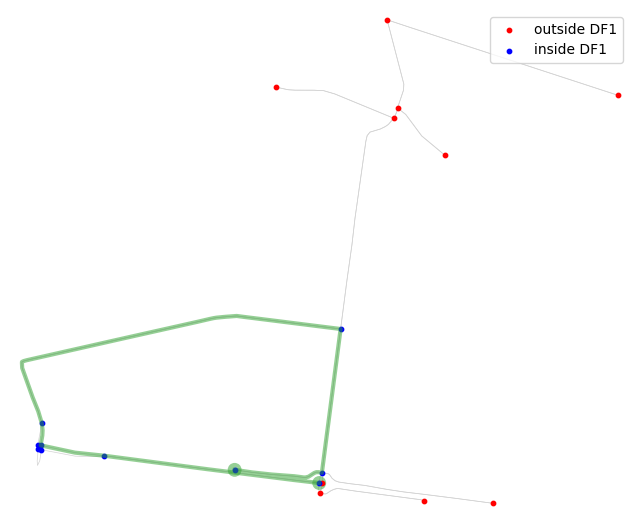

In [126]:
start_node = ox.nearest_nodes(g_sub, 51.473609, 5.738671)
end_node = list(g_sub.nodes)[1]
print("Start node:", start_node)
print("End node:", end_node)
shortest_path = nx.shortest_path(g_sub, start_node, end_node, weight='length')
print(shortest_path)
plot_with_route(g_sub, g_pt, shortest_path)

In [118]:
def plot_with_route(G_sub, G_pt, route=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))

    # draw base graph
    ox.plot_graph(
        G_pt, ax=ax, show=False, close=False,
        node_size=0, edge_color='lightgray',
        edge_linewidth=0.5, bgcolor='white'
    )

    # optionally draw the route
    if route is not None:
        ox.plot_graph_route(
            G_pt,
            route,
            route_color='tab:green',
            route_linewidth=3,
            ax=ax,
            show=False,
            close=False,
            orig_dest_node_size=0
        )

    # then your inside/outside scatters...
    pos = {nid: (data['x'], data['y']) for nid, data in G_pt.nodes(data=True)}
    inside = set(G_sub.nodes())
    outside = set(G_pt.nodes()) - inside

    ax.scatter([pos[n][0] for n in outside],
               [pos[n][1] for n in outside],
               c='red', s=10, label='outside DF1')
    ax.scatter([pos[n][0] for n in inside],
               [pos[n][1] for n in inside],
               c='blue', s=10, label='inside DF1')

    ax.legend()
    return ax

<Axes: >

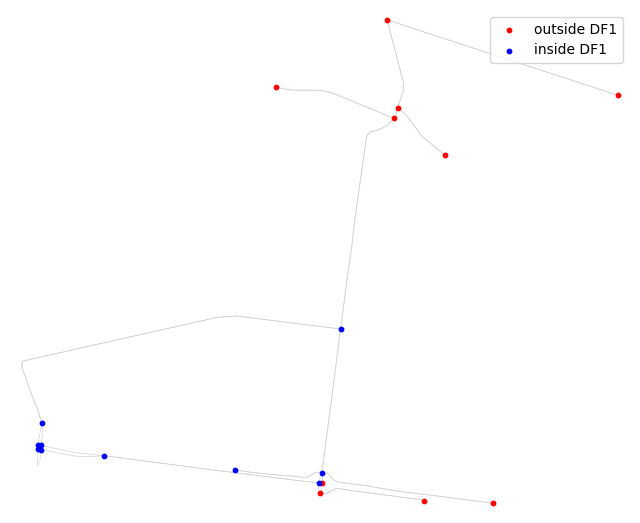

In [109]:
plot_with_route(g_sub, g_pt)